#### CNN Model:

In [8]:
# libraries cnn model
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std
from tensorflow import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, roc_curve, auc)

import plotly.figure_factory as ff

import os
import scipy.io as sio
from scipy.fft import fft

import matplotlib.pyplot as plt

In [2]:
# load the dataset, returns train, test and validation X and y elements
def load_dataset():

	# load all data
	with open('data/processed/trainX.npy', 'rb') as f:
		trainX = np.load(f)
	with open('data/processed/trainy.npy', 'rb') as f:
		trainy = np.load(f)
	with open('data/processed/testX.npy', 'rb') as f:
		testX = np.load(f)
	with open('data/processed/testy.npy', 'rb') as f:
		testy = np.load(f)
	
	print("train: ",trainX.shape, trainy.shape, "\ntest: ", testX.shape, testy.shape,"\n")
	
	return trainX, trainy, testX, testy

In [3]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):

    verbose, epochs, batch_size = 2, 20, 32
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    model = Sequential()
    model.add(Conv1D(filters=3, kernel_size=5, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    pred_train = model.predict(trainX, verbose=0)
    pred_test = model.predict(testX, verbose=0)
    
    # save model
    models_dir = 'models/'
    existing_models = [filename for filename in os.listdir(models_dir) if filename.startswith('cnn_model')]
    num_model = len(existing_models)+1
    filename = f'models/cnn_model_{num_model}.h5'
    model.save(filename)

    return accuracy, pred_train, pred_test

In [4]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [3]:
trainX, trainy, testX, testy = load_dataset()

train:  (49209, 512, 2) (49209, 3) 
test:  (10545, 512, 2) (10545, 3) 



In [6]:
pd.DataFrame(np.argmax(trainy,axis=1)).value_counts()

1    16899
0    16885
2    15425
dtype: int64

In [7]:
pd.DataFrame(np.argmax(testy,axis=1)).value_counts()

1    3600
0    3552
2    3393
dtype: int64

In [8]:
# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	train_accs = list()
	test_accs = list()
	for r in range(repeats):
		score, pred_train, pred_test = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('\n>#%d: %.3f\n' % (r+1, score))
		scores.append(score)
		train_acc = accuracy_score(np.argmax(trainy,axis=1), np.argmax(pred_train,axis=1))*100
		test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))*100
		train_accs.append(train_acc)
		test_accs.append(test_acc)

	# summarize results
	summarize_results(scores)
	print('\nTrain accuracy: ')
	summarize_results(train_accs)
	print('Test accuracy: ')
	summarize_results(test_accs)


In [21]:
# run the experiment
run_experiment(4)

train:  (49209, 512, 2) (49209, 3) 
test:  (10545, 512, 2) (10545, 3) 

Epoch 1/20
1538/1538 - 8s - loss: 17.9090 - accuracy: 0.4372 - 8s/epoch - 5ms/step
Epoch 2/20
1538/1538 - 6s - loss: 0.7433 - accuracy: 0.6627 - 6s/epoch - 4ms/step
Epoch 3/20
1538/1538 - 7s - loss: 0.5889 - accuracy: 0.7404 - 7s/epoch - 4ms/step
Epoch 4/20
1538/1538 - 6s - loss: 0.5089 - accuracy: 0.7828 - 6s/epoch - 4ms/step
Epoch 5/20
1538/1538 - 7s - loss: 0.4339 - accuracy: 0.8190 - 7s/epoch - 4ms/step
Epoch 6/20
1538/1538 - 6s - loss: 0.3790 - accuracy: 0.8438 - 6s/epoch - 4ms/step
Epoch 7/20
1538/1538 - 7s - loss: 0.3319 - accuracy: 0.8651 - 7s/epoch - 4ms/step
Epoch 8/20
1538/1538 - 6s - loss: 0.3120 - accuracy: 0.8717 - 6s/epoch - 4ms/step
Epoch 9/20
1538/1538 - 7s - loss: 0.2907 - accuracy: 0.8823 - 7s/epoch - 4ms/step
Epoch 10/20
1538/1538 - 6s - loss: 0.2699 - accuracy: 0.8915 - 6s/epoch - 4ms/step
Epoch 11/20
1538/1538 - 6s - loss: 0.2519 - accuracy: 0.8991 - 6s/epoch - 4ms/step
Epoch 12/20
1538/1538 -

In [16]:
# load data
trainX, trainy, testX, testy = load_dataset()

score, pred_train, pred_test = evaluate_model(trainX, trainy, testX, testy)
train_acc = accuracy_score(np.argmax(trainy,axis=1), np.argmax(pred_train,axis=1))
test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Train accuracy: ',train_acc)
print('Test accuracy: ',test_acc)

train:  (49209, 512, 2) (49209, 3) 
test:  (10545, 512, 2) (10545, 3) 

Epoch 1/20
1538/1538 - 16s - loss: 0.5176 - accuracy: 0.7702 - 16s/epoch - 11ms/step
Epoch 2/20
1538/1538 - 12s - loss: 0.3273 - accuracy: 0.8676 - 12s/epoch - 7ms/step
Epoch 3/20
1538/1538 - 12s - loss: 0.2793 - accuracy: 0.8904 - 12s/epoch - 8ms/step
Epoch 4/20
1538/1538 - 11s - loss: 0.2455 - accuracy: 0.9020 - 11s/epoch - 7ms/step
Epoch 5/20
1538/1538 - 13s - loss: 0.2219 - accuracy: 0.9125 - 13s/epoch - 9ms/step
Epoch 6/20
1538/1538 - 12s - loss: 0.2037 - accuracy: 0.9194 - 12s/epoch - 8ms/step
Epoch 7/20
1538/1538 - 12s - loss: 0.1842 - accuracy: 0.9273 - 12s/epoch - 8ms/step
Epoch 8/20
1538/1538 - 12s - loss: 0.1718 - accuracy: 0.9314 - 12s/epoch - 8ms/step
Epoch 9/20
1538/1538 - 11s - loss: 0.1603 - accuracy: 0.9365 - 11s/epoch - 7ms/step
Epoch 10/20
1538/1538 - 12s - loss: 0.1516 - accuracy: 0.9387 - 12s/epoch - 8ms/step
Epoch 11/20
1538/1538 - 12s - loss: 0.1407 - accuracy: 0.9434 - 12s/epoch - 8ms/step
E

In [9]:
print(classification_report(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1), target_names=['Healthy', 'OR fault', 'IR fault'],digits=4))

              precision    recall  f1-score   support

     Healthy     0.9309    0.9589    0.9447      3552
    OR fault     0.9657    0.9469    0.9562      3600
    IR fault     0.9201    0.9101    0.9151      3393

    accuracy                         0.9391     10545
   macro avg     0.9389    0.9386    0.9387     10545
weighted avg     0.9393    0.9391    0.9391     10545



In [7]:
# Construimos una visualización para la matriz de confusión
z_test = confusion_matrix(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
# Reformateo la matriz para que me quede mejor el gráfico
z_test[[0,2],:] = z_test[[2,0],:]
x = ['Healthy', 'OR fault', 'IR fault']
y = ['IR fault', 'OR fault', 'Healthy']

def format_text(z):
    return f'{z}<br>({z / np.sum(z_test) * 100:.1f}%)'

z_text = np.vectorize(format_text)(z_test)

heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='cividis')
heatmap.update_layout(title_text='CNN Model',height=350,width=500,
                      xaxis_title="Predicted Label",yaxis_title="True Label")
heatmap.show()

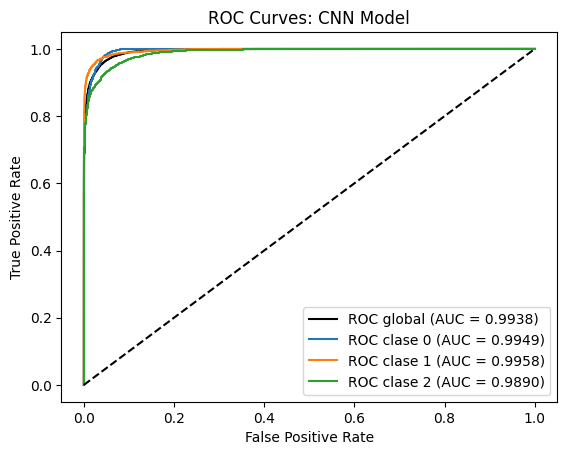

In [9]:
# Obtener las curvas ROC y los valores de AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(testy[:, i], pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Obtener la curva ROC global
fpr["micro"], tpr["micro"], _ = roc_curve(testy.ravel(), pred_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficamos la curva ROC global y las curvas ROC de cada clase
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label="ROC global (AUC = {:.4f})".format(roc_auc["micro"]), color="black")
for i in range(3):
    plt.plot(fpr[i], tpr[i], label="ROC class {} (AUC = {:.4f})".format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: CNN Model")
plt.legend()
plt.show()

Check if it is making more mistakes for one specific speed setting.

In [19]:
# setting
indicesMistakes = np.where((np.argmax(testy,axis=1) != np.argmax(pred_test,axis=1)))[0]
testX_mistakes = testX[indicesMistakes]
pd.DataFrame(testX_mistakes[:,0,1]).value_counts()

# Mistakes are quite balanced between samples with 900 and 1500 rpm for rotational speed
# but the testX only had 1/4 of data of 900 rpm
# so the proportion is bigger

0.0    354
1.0    288
dtype: int64